In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import os
import shutil

import sys
sys.path.append("../")
from dual_process import dig_helpers, dig_pipeline, dig_viz

/home/coder/miniconda3/envs/dig/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Config and Models**

This demo is pre-loaded with Flux Schnell as the image generator and Idefics2 as the VLM; you can change the models via `pipe_name` and `vlm_name`.

In [2]:
pipe_name = "schnell" # official: ["schnell", "dev"], experimental: ["sd", "sana"]
vlm_name = "idefics2" # official: ["idefics2", "qwenvl"], experimental: ["gemma3", "llava", "pixtral"]

In [ ]:
config_names = ["configs/base.yaml", f"configs/pipe/{pipe_name}.yaml", f"configs/vlm/{vlm_name}.yaml"]
config = dig_helpers.load_config(config_names)
pipe = dig_helpers.load_pipe(**config["pipe_kwargs"])
vlm, vlm_processor = dig_helpers.load_vlm(**config["vlm_kwargs"])

**Set Hparams**

All the default hyperparameters are set in `configs/base.yaml`. Below, we surface a few hyperparameters you might be interested in adjusting. 

By default, each optimization step uses a new random seed.
If you want the LoRA to be more subtle and consistent
with the original image, you can set `opt_kwargs.train_n=1` (and lower the number of optimization steps and learning rate accordingly).

In [4]:
config["lora_kwargs"]["lora_lr"] = 5e-5 # the learning rate
config["lora_kwargs"]["r"] = 16 # the LoRA rank
config["opt_kwargs"]["train_weight"] = 5 # the LoRA weight, where `alpha = weight * rank`
config["opt_kwargs"]["num_opt_steps"] = 100 # the number of optimization steps
config["opt_kwargs"]["train_n"] = config["opt_kwargs"]["num_opt_steps"] # the number of seeds to train on

**Format Data**

Define the prompt for the image you want to generate, and a question-answer pair to check.
To find examples of other inputs, look at the yaml files in `configs/dataset`.

In [5]:
# inputs to image generator
prompt = "Photo of a man"

# inputs to VLM
question = "Is the man smiling?"
answer = "Yes"
question_postfix = "Answer with Yes or No."

# inputs for VLM visual prompting
ref_images = None
overlay_mode = None

In [6]:
qa_pairs = [{"question": question, "answer": answer, "ref_images": ref_images, "overlay_mode": overlay_mode}]
config["question_postfix"] = question_postfix

**Run Dual Process Image Generation**

Run dual process image generation, which optimizes the image generator LoRA with gradients from the VLM. 

You can toggle the interval at which the optimization cell logs intermediate outputs with `eval_interactive`.
The left image is the result *without* the Dual Process LoRA, and the right image is the result *with* the Dual Process LoRA.
Above each image is VLM's predicted answer, then the probability of the ground-truth answer.

In [7]:
edit = dig_pipeline.create_edit(pipe, vlm, vlm_processor, config, qa_pairs, prompt)
params = dig_helpers.create_lora(pipe, **config["lora_kwargs"])

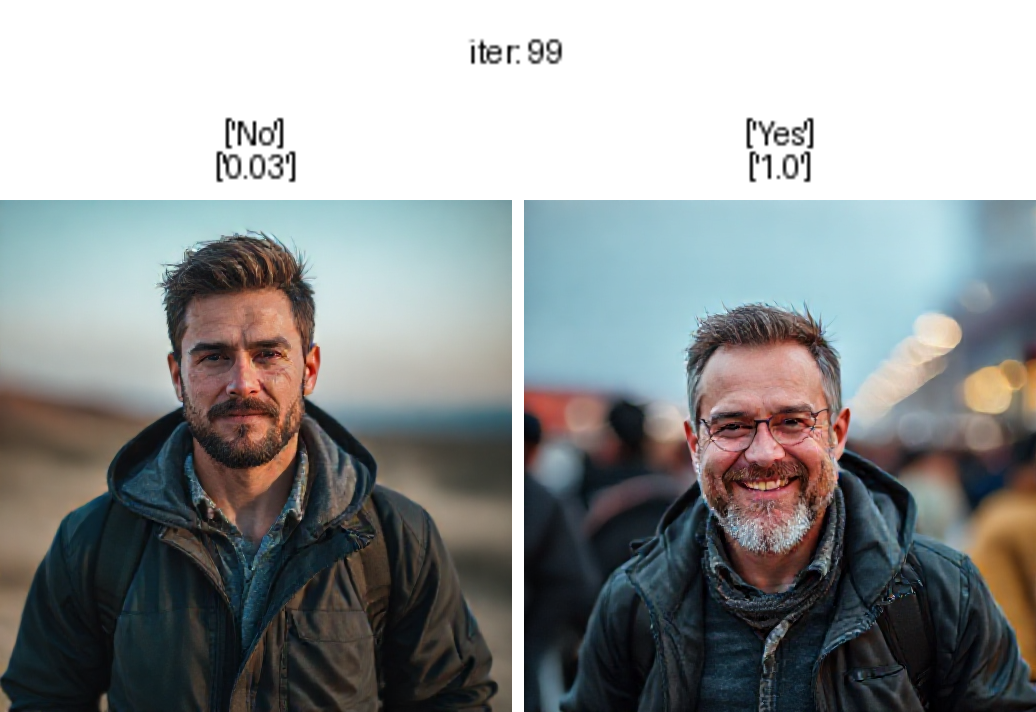

100%|██████████| 100/100 [03:36<00:00,  2.16s/it, loss=0.00105]


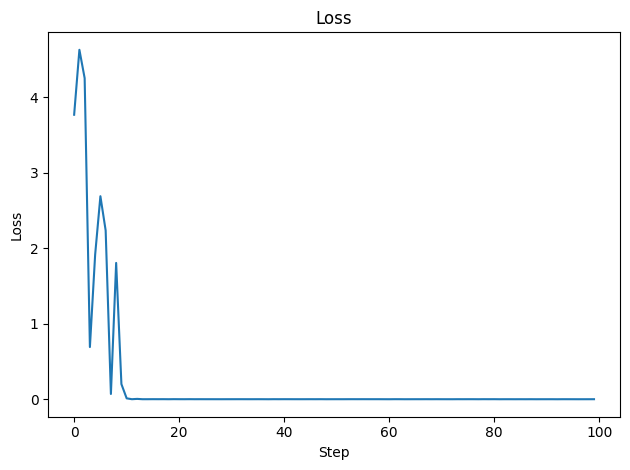

In [8]:
eval_interactive = 1
results = dig_pipeline.optimize(pipe, edit, config["opt_kwargs"], config["generator_kwargs"], [params], prompt=prompt, save_folder="interactive", config=config, eval_interactive=eval_interactive)

**Generate Images with Optimized Dual Process LoRA**

Once you have an optimized LoRA, it's easy to generate new images with the same control.
You can evaluate the LoRA on the same prompt you optimized with, or a new one.

In [23]:
eval_prompt = "photo of a woman"

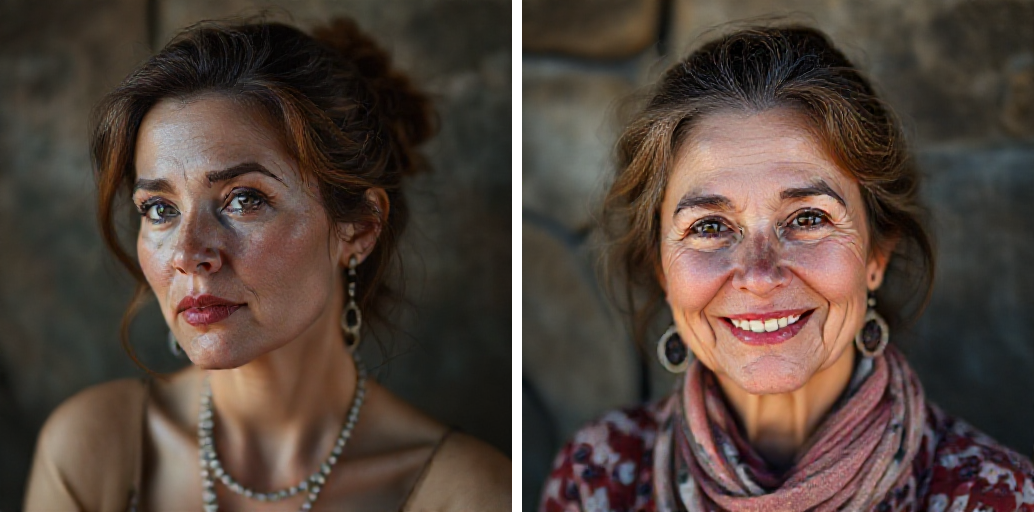

In [24]:
eval_seed = 0
eval_n = 1
weights = [0, config["opt_kwargs"]["train_weight"]]

eval_images = dig_pipeline.run_eval(pipe, config["generator_kwargs"], eval_prompt, weights, eval_n, eval_seed)
grid = dig_viz.view_images(eval_images, eval_n)
grid